In [1]:
%matplotlib inline

from __future__ import print_function

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

import numpy as np
import matplotlib.pyplot as plt
import pandas
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')

In [2]:
# fix random seed for reproducibility
np.random.seed(10)

In [3]:
# sử dụng tập dữ liệu từ food_train.csv
dataframe = pandas.read_csv('file_resut_2.csv', usecols=[1], engine='python', skipfooter=3)
dataset   = dataframe.values
dataframe.head()

,waterlevel
0,39.033386
1,39.033386
2,27.000000
3,28.000000
4,28.000000


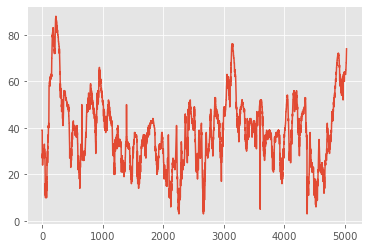

In [4]:
plt.plot(dataset)

In [5]:
# Chuyển tập dữ liệu về trong khoảng (0, 1)
scaler  = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [6]:
# Chia thành tập huấn luyện và tập kiểm tra
train_size  = int(len(dataset) * 0.8)
test_size   = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

4024 1007


----------------- TRAINING DATA -----------------


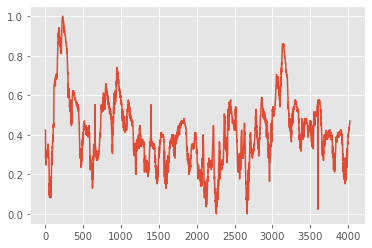

----------------- TEST DATA -----------------


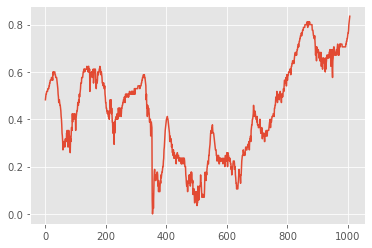

In [7]:
print('----------------- TRAINING DATA -----------------')
plt.plot(train)
plt.show()
print('----------------- TEST DATA -----------------')
plt.plot(test)
plt.show()

In [8]:
# Hàm này tạo một cửa sổ trượt của tập dữ liệu.
def create_dataset(dataset, sliding_window=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-sliding_window-1):
        a = dataset[i:(i+sliding_window), 0]
        dataX.append(a)
        dataY.append(dataset[i + sliding_window, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
# sử dụng cửa sổ trượt n-10 tương đương với 2,5 giờ dữ liệu lịch sử
slide_window   = 10
trainX, trainY = create_dataset(train, slide_window)
testX, testY   = create_dataset(test, slide_window)

In [10]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [11]:
#Thiết lập LSTM

model = Sequential()
model.add(LSTM(4, input_dim=slide_window))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
4013/4013 - 12s - loss: 0.0033 - 12s/epoch - 3ms/step
Epoch 2/5
4013/4013 - 9s - loss: 7.6790e-04 - 9s/epoch - 2ms/step
Epoch 3/5
4013/4013 - 9s - loss: 7.2251e-04 - 9s/epoch - 2ms/step
Epoch 4/5
4013/4013 - 8s - loss: 7.0202e-04 - 8s/epoch - 2ms/step
Epoch 5/5
4013/4013 - 8s - loss: 6.7737e-04 - 8s/epoch - 2ms/step


In [12]:
# In ra đánh giá cho cả hai
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(np.array([[trainScore]]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = model.evaluate(testX, testY, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 6.25 RMSE
Test Score: 6.34 RMSE


32/32 [==============================] - 0s 2ms/step


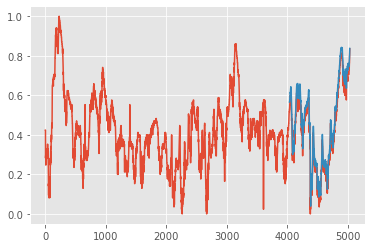

In [13]:
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)
 
# Dữ liệu dự đoán
testPredictPlot       = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(slide_window*2)+1:len(dataset)-1, :] = testPredict
 
# Vẽ dữ liệu thực tế và dữ liệu dự đoán
plt.plot(dataset)
plt.plot(testPredictPlot)
plt.show()

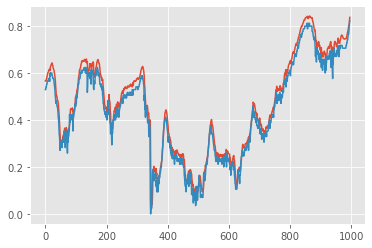

In [14]:
plt.plot(testPredict)
plt.plot(testY)